### **Name** : *Tazmeen Afroz*
### **Student_ID** : *22P-9252*
### **Assignment No 2**

## Import libraries

In [1]:
import math
import random
import networkx as nx
import matplotlib.pyplot as plt
import queue
from collections import deque
from itertools import permutations
from itertools import permutations


#  Function to Visualize the Graph

In [2]:
def visualize_graph(data):
   
    # In this graph, each node will represent a node from our data, 
    # and each directed edge will represent a parent-child relationship.
    G = nx.DiGraph()

    # We then iterate over our data. The data is a dictionary where each key is a node, 
    # and each value is a list of tuples. Each tuple contains a list of parents and a weight.
    for node, info in data.items():
        for parents, weight in info:
          
            G.add_node(node, weight=weight)

            # For each parent of the current node, we add a directed edge from the parent to the node.
            for parent in parents:
                G.add_edge(parent, node)

    # printing all the nodes, all the edges, 
    # all the nodes with their attributes, and all the edges with their attributes.
    print(G.nodes())
    print(G.edges())
    print(G.nodes(data=True))
    print(G.edges(data=True))

    # Here, we draw the graph with labels.
    nx.draw(G, with_labels=True)
   
    plt.show()



# Function to read files


In [3]:
def read_text_files(filename):
    # empty dictionary .
    data = {}

    with open(filename, 'r') as file:
        # read each line one by one.
        for line in file:
            # We split the line into a node and the rest of the line.
            # The 'strip' function removes any leading or trailing whitespace from the line.
            # The 'split' function splits the line into parts based on the comma separator.
            # The '1' argument tells the 'split' function to split the line into at most 2 parts.
            node, rest = line.strip().split(',', 1)

            # We split the rest of the line into parents and weight.
            # The 'rsplit' function splits the line into parts based on the comma separator, starting from the end of the line.
            parents, weight = rest.rsplit(',', 1)

            node = int(node)  # The node is an integer.
            parents = eval(parents)  # The parents are a list or tuple, represented as a string in the file.
            weight = float(weight)  # The weight is a floating-point number.

            
            # If the node is not already in our data, we add an empty list for it.
            if node not in data:
                data[node] = []
            # We append a tuple containing the parents and weight to the list for this node.
            data[node].append((parents, weight))


    return data

### Storing the files data

In [4]:
data0 = read_text_files('data0.txt')
data1 = read_text_files('data1.txt')
data2 = read_text_files('data2.txt')
data3 = read_text_files('data3.txt')


## Function to calculate cost

In [5]:
def calculate_cost(ordering, data_dict):
    # We start with a total cost of 0
    total_cost = 0

    # We go through each node in our ordering
    for i, node in enumerate(ordering):
        # We create a list to store the weights of all valid parent sets for this node
        valid_weights = []

        # We look at all the parent sets for this node in our data
        for info in data_dict[node]:
            # Each info is a pair: a list of parents and a weight
            parents, weight = info

            # We start by assuming that all parents come before our node in the ordering
            all_parents_before = True

            # We look at each parent
            for parent in parents:
            # If a parent does not come before our node in the ordering, we set all_parents_before to False
              if parent not in ordering[:i]:
                all_parents_before = False
                break

            # If all parents come before our node, we add the weight to our list of valid weights
            if all_parents_before:
                valid_weights.append(weight)

        # If there are any valid parent sets, we find the one with the minimum weight and add it to the total cost
        if valid_weights:
            total_cost += min(valid_weights)

    # We return the total cost of this ordering
    return total_cost

# Hill Climbing

In [6]:
def hill_climbing(initial_ordering, data_dict):
    # We start with the initial ordering and calculate its cost
    current_ordering = initial_ordering
    current_cost = calculate_cost(current_ordering, data_dict)

    # We keep trying to find a better ordering until we can't find one
    while True:
        # We'll store all the neighboring orderings and their costs here
        neighbors = []

        # We generate all the neighboring orderings by reversing all possible sublists
        for i in range(len(current_ordering)):
            for j in range(i+1, len(current_ordering)):
                # We create a new ordering by reversing the sublist from i to j
                new_ordering = current_ordering[:i] + current_ordering[i:j+1][::-1] + current_ordering[j+1:]
                # We calculate the cost of the new ordering
                new_cost = calculate_cost(new_ordering, data_dict)
                # We add the new ordering and its cost to our list of neighbors
                neighbors.append((new_ordering, new_cost))

        # We find the neighbor with the lowest cost
        min_cost = float('inf')
        next_ordering = None
        for ordering, cost in neighbors:
            if cost < min_cost:
                min_cost = cost
                next_ordering = ordering

        # If the lowest cost neighbor is better than the current ordering, we move to that ordering
        if min_cost < current_cost:
            current_ordering, current_cost = next_ordering, min_cost
        else:
            # If no neighbor is better, we return the current ordering and its cost
            return current_ordering, current_cost

# Simulated Annealing

In [7]:
def simulated_annealing(initial_ordering, data_dict, T=1.0, T_min=0.00001, alpha=0.9):
    # We start with the initial ordering and calculate its cost
    current_ordering = initial_ordering
    current_cost = calculate_cost(current_ordering, data_dict)

    # We keep trying to find a better ordering until the temperature is too low
    while T > T_min:
        # We randomly select two indices in the ordering
        indices = random.sample(range(len(current_ordering)), 2)
        indices.sort()
        i, j = indices

        # We create a new ordering by reversing the sublist from i to j
        new_ordering = list(current_ordering)  # Make a copy of the current ordering
        sublist = new_ordering[i:j+1]  # Get the sublist
        sublist.reverse()  # Reverse the sublist
        new_ordering[i:j+1] = sublist  # Replace the sublist in the new ordering

        # We calculate the cost of the new ordering
        new_cost = calculate_cost(new_ordering, data_dict)

        # We calculate the difference in cost between the new ordering and the current ordering
        delta = new_cost - current_cost

        # If the new ordering is better (i.e., has a lower cost), we move to it
        # If the new ordering is worse, we might still move to it with a certain probability
        '''
        random.uniform(0, 1) generates a random number between 0 and 1.
        math.exp(-delta / T) calculates the acceptance probability for the worse solution. 
        This probability is higher when T (the "temperature") is high, and it gets lower as T decreases.
        The delta in the numerator makes the probability lower if the new solution is much worse than the current one.

        '''
        if delta < 0 or random.uniform(0, 1) < math.exp(-delta / T):
            current_ordering, current_cost = new_ordering, new_cost

        # We decrease the temperature
        T = T * alpha

    # We return the final ordering and its cost
    return current_ordering, current_cost

# A* Search

In [8]:

def a_star(initial_ordering, data_dict):
    # We start with a priority queue and add the initial ordering with its cost
    pq = queue.PriorityQueue()
    pq.put((calculate_cost(initial_ordering, data_dict), initial_ordering))

    # We keep track of the orderings we have already visited
    visited = set()

    # We keep trying to find a better ordering until the priority queue is empty
    while not pq.empty():
        # We get the ordering with the lowest cost from the priority queue
        cost, ordering = pq.get()

        # We convert the ordering to a tuple so we can add it to our set of visited orderings
        ordering_tuple = tuple(ordering)

        # If we have already visited this ordering, we skip it
        if ordering_tuple in visited:
            continue

        # We add the ordering to our set of visited orderings
        visited.add(ordering_tuple)

        # If we have found an ordering that includes all nodes, we return it and its cost
        if len(ordering) == len(data_dict):
            return ordering, cost

        # We generate all the neighboring orderings by reversing all possible sublists
        for i in range(len(ordering)):
            for j in range(i+1, len(ordering)):
                # We create a new ordering by reversing the sublist from i to j
                new_ordering = ordering[:i] + ordering[i:j+1][::-1] + ordering[j+1:]
                # We calculate the cost of the new ordering
                new_cost = calculate_cost(new_ordering, data_dict)
                # We add the new ordering and its cost to our priority queue
                pq.put((new_cost, new_ordering))


# BFS

In [9]:

def bfs(data_dict):
    # We start by getting a list of all nodes
    nodes = list(data_dict.keys())

    # We generate all permutations of the nodes
    permutations_generator = permutations(nodes)

    # We keep track of the orderings we have already visited
    visited = set()

    # We initialize the minimum cost to infinity and the ordering that gives the minimum cost to None
    min_cost = float('inf')
    min_cost_ordering = None

    # We go through each permutation
    for ordering in permutations_generator:
        # If we have already visited this ordering, we skip it
        if ordering in visited:
            continue

        # We add the ordering to our set of visited orderings
        visited.add(ordering)

        # We calculate the cost of the ordering
        cost = calculate_cost(ordering, data_dict)

        # If the cost of the ordering is less than the minimum cost, we update the minimum cost and the ordering that gives the minimum cost
        if cost < min_cost:
            min_cost = cost
            min_cost_ordering = ordering

    # We return the ordering that gives the minimum cost and the minimum cost
    return min_cost_ordering, min_cost

# DFS

In [10]:
def dfs(data_dict):
    # We start by getting a list of all nodes
    nodes = list(data_dict.keys())

    # We generate all permutations of the nodes
    permutations_generator = permutations(nodes)

    # We keep track of the orderings we have already visited
    visited = set()

    # We initialize the minimum cost to infinity and the ordering that gives the minimum cost to None
    min_cost = float('inf')
    min_cost_ordering = None

    # We go through each permutation
    for ordering in permutations_generator:
        # If we have already visited this ordering, we skip it
        if ordering in visited:
            continue

        # We add the ordering to our set of visited orderings
        visited.add(ordering)

        # We calculate the cost of the ordering
        cost = calculate_cost(ordering, data_dict)

        # If the cost of the ordering is less than the minimum cost, we update the minimum cost and the ordering that gives the minimum cost
        if cost < min_cost:
            min_cost = cost
            min_cost_ordering = ordering

    # We return the ordering that gives the minimum cost and the minimum cost
    return min_cost_ordering, min_cost

## File 0 

[1, 3, 4, 5, 2]
[(1, 3), (1, 4), (1, 5), (3, 1), (3, 2), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (2, 3), (2, 4), (2, 5)]
[(1, {'weight': 99.835}), (3, {'weight': 41.775}), (4, {'weight': 36.188}), (5, {'weight': 36.508}), (2, {'weight': 123.398})]
[(1, 3, {}), (1, 4, {}), (1, 5, {}), (3, 1, {}), (3, 2, {}), (3, 4, {}), (3, 5, {}), (4, 1, {}), (4, 2, {}), (4, 3, {}), (4, 5, {}), (5, 1, {}), (5, 2, {}), (5, 3, {}), (5, 4, {}), (2, 3, {}), (2, 4, {}), (2, 5, {})]


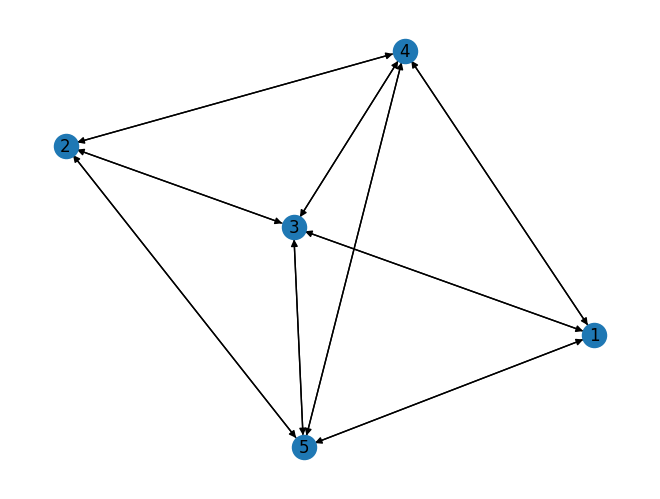

In [11]:

visualize_graph(data0)

In [12]:
print('Data 0:', data0)
initial_ordering = list(data0.keys())
print('Hill Climbing:', hill_climbing(initial_ordering, data0))
print('Simulated Annealing:', simulated_annealing(initial_ordering, data0))
print('A*:', a_star(initial_ordering, data0))
print('BFS:', bfs(data0))
print('DFS:', dfs(data0))



Data 0: {1: [({}, 153.466), ({3}, 96.093), ({4}, 97.913), ({5}, 99.835)], 2: [({}, 141.023), ({3}, 122.446), ({4}, 121.576), ({5}, 123.398)], 3: [({}, 169.482), ({1}, 112.109), ({2}, 150.906), ({1, 2}, 107.516), ({4}, 51.681), ({5}, 41.775)], 4: [({}, 169.482), ({1}, 113.929), ({2}, 150.036), ({1, 2}, 108.982), ({3}, 51.681), ({5}, 36.188)], 5: [({}, 169.802), ({1}, 116.171), ({2}, 152.178), ({1, 2}, 111.473), ({3}, 42.096), ({4}, 36.508)]}
Hill Climbing: ([5, 4, 3, 1, 2], 465.43399999999997)
Simulated Annealing: ([5, 4, 3, 1, 2], 465.43399999999997)
A*: ([1, 2, 3, 4, 5], 490.194)
BFS: ((4, 2, 5, 3, 1), 465.43399999999997)
DFS: ((4, 2, 5, 3, 1), 465.43399999999997)


## File 1

[1, 2, 3, 4, 5, 10, 12, 14, 15, 16, 17, 18, 6, 11, 8, 7, 9, 13]
[(1, 2), (1, 3), (1, 4), (1, 5), (1, 10), (1, 12), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (2, 1), (2, 6), (2, 11), (2, 16), (2, 18), (3, 1), (3, 4), (3, 10), (3, 14), (3, 16), (4, 1), (4, 3), (4, 10), (4, 11), (4, 12), (4, 14), (4, 17), (4, 18), (5, 1), (5, 8), (5, 11), (5, 12), (5, 14), (5, 16), (5, 17), (5, 18), (10, 1), (10, 3), (10, 4), (10, 6), (10, 9), (10, 14), (10, 17), (10, 18), (12, 1), (12, 4), (12, 5), (12, 14), (12, 17), (14, 1), (14, 3), (14, 4), (14, 5), (14, 10), (14, 11), (14, 12), (14, 15), (14, 16), (14, 18), (15, 1), (15, 14), (15, 16), (15, 17), (15, 18), (16, 1), (16, 2), (16, 3), (16, 5), (16, 13), (16, 14), (16, 15), (17, 1), (17, 4), (17, 5), (17, 8), (17, 9), (17, 10), (17, 11), (17, 12), (17, 15), (17, 18), (18, 1), (18, 2), (18, 4), (18, 5), (18, 6), (18, 8), (18, 10), (18, 11), (18, 14), (18, 15), (18, 17), (6, 2), (6, 7), (6, 10), (6, 11), (6, 18), (11, 2), (11, 4), (11, 5), (11, 6), (11

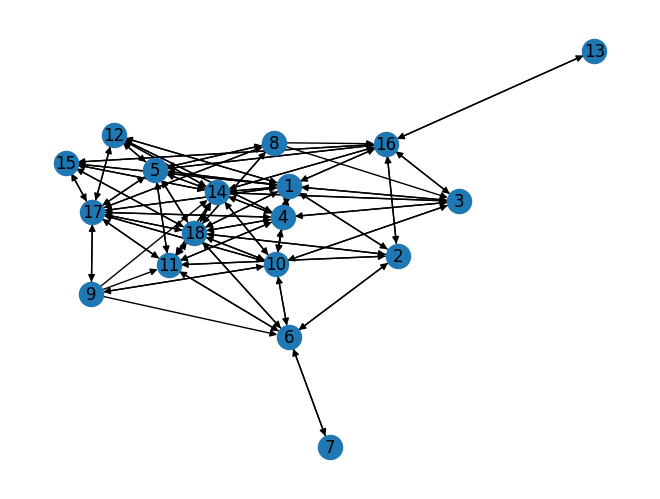

In [13]:
visualize_graph(data1)

In [14]:

initial_ordering = list(data1.keys())
print('Hill Climbing:', hill_climbing(initial_ordering, data1))
print('Simulated Annealing:', simulated_annealing(initial_ordering, data1))
print('A*:', a_star(initial_ordering, data1))

    

Hill Climbing: ([1, 5, 4, 3, 11, 6, 7, 8, 17, 16, 2, 12, 13, 14, 15, 10, 9, 18], 3196.7529999999992)
Simulated Annealing: ([5, 1, 2, 4, 3, 6, 17, 16, 7, 12, 15, 8, 14, 10, 13, 9, 18, 11], 3199.6539999999995)
A*: ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], 3211.6850000000004)


## File 2

[1, 3, 6, 8, 9, 10, 12, 14, 16, 19, 2, 4, 5, 7, 17, 18, 11, 13, 15]
[(1, 3), (1, 6), (1, 8), (1, 9), (1, 10), (1, 12), (1, 14), (1, 16), (1, 19), (3, 1), (3, 4), (3, 5), (3, 6), (3, 7), (3, 12), (3, 14), (3, 16), (6, 1), (6, 3), (6, 4), (6, 5), (6, 7), (6, 8), (8, 1), (8, 4), (8, 5), (8, 6), (8, 10), (8, 19), (9, 1), (9, 11), (9, 14), (9, 16), (9, 17), (9, 18), (9, 19), (10, 1), (10, 8), (10, 12), (12, 1), (12, 3), (12, 10), (12, 11), (12, 13), (12, 16), (14, 1), (14, 3), (14, 9), (14, 13), (14, 16), (16, 1), (16, 3), (16, 9), (16, 11), (16, 12), (16, 13), (16, 14), (16, 19), (19, 1), (19, 5), (19, 8), (19, 9), (19, 11), (19, 16), (19, 18), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (5, 3), (5, 4), (5, 6), (5, 7), (5, 8), (5, 17), (5, 19), (7, 3), (7, 4), (7, 5), (7, 6), (7, 18), (17, 5), (17, 6), (17, 9), (17, 11), (17, 13), (17, 18), (18, 7), (18, 9), (18, 13), (18, 15), (18, 17), (18, 19), (11, 9), (11, 12), (11, 16), (11, 17), (11, 19), (13, 12), (13, 14), (13, 16), (13, 17), (13, 18)

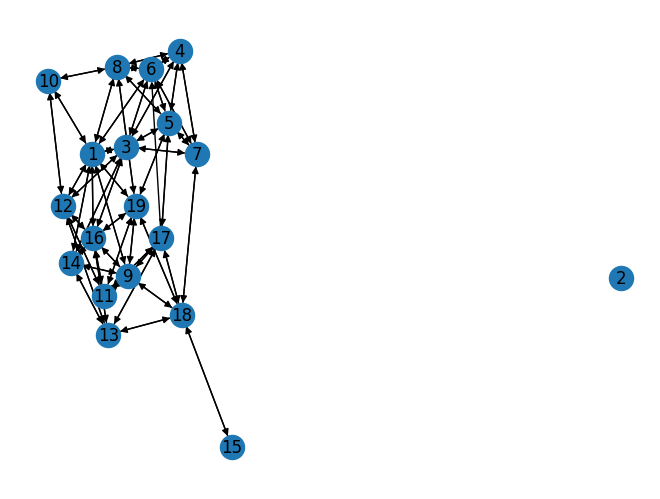

In [15]:
visualize_graph(data2)

In [16]:

initial_ordering = list(data2.keys())
print('Hill Climbing:', hill_climbing(initial_ordering, data2))
print('Simulated Annealing:', simulated_annealing(initial_ordering, data2))
print('A*:', a_star(initial_ordering, data2))


Hill Climbing: ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 19, 16, 17, 18, 15, 14, 13], 1976.539)
Simulated Annealing: ([4, 5, 2, 3, 6, 8, 1, 15, 14, 10, 9, 7, 11, 19, 16, 18, 13, 12, 17], 1975.7719999999997)
A*: ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 1995.5119999999997)


## File 3

[1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 16, 5, 6]
[(1, 2), (1, 3), (1, 4), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 17), (1, 18), (1, 19), (2, 1), (2, 3), (2, 4), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 16), (2, 17), (2, 18), (2, 19), (3, 1), (3, 2), (3, 4), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 16), (3, 17), (3, 18), (3, 19), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 17), (4, 18), (4, 19), (7, 1), (7, 2), (7, 3), (7, 4), (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13), (7, 14), (7, 16), (7, 17), (7, 18), (7, 19), (8, 1), (8, 2), (8, 3), (8, 4), (8, 7), (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (8, 17), (8, 18), (8, 19), (9, 1), (9, 2), (9, 3), (9, 4), (9, 7), (9, 8), (9, 10), (9, 11), (9, 12), (9, 13), (9, 14), (9, 17), (9, 18), (9, 19), (10, 1), (10, 2), (10, 3), (10, 4), (10, 7), (10, 8), (10

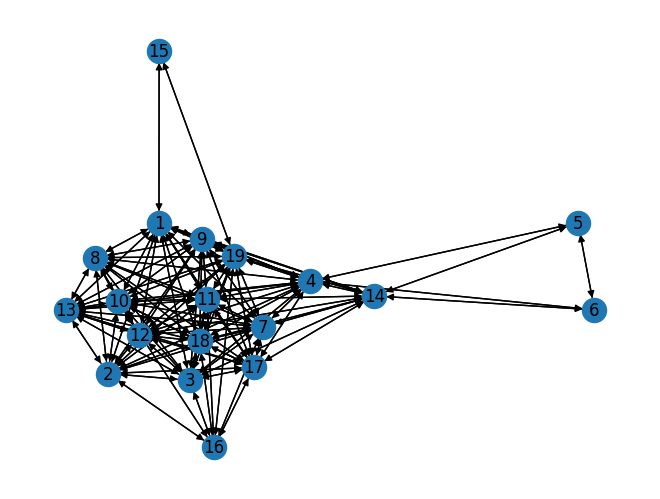

In [17]:
visualize_graph(data3)

In [18]:

initial_ordering = list(data3.keys())
print('Hill Climbing:', hill_climbing(initial_ordering, data3))
print('Simulated Annealing:', simulated_annealing(initial_ordering, data3))
print('A*:', a_star(initial_ordering, data3))


Hill Climbing: ([9, 12, 11, 18, 2, 10, 1, 13, 14, 5, 6, 7, 8, 19, 3, 4, 15, 16, 17], 7974.520999999998)
Simulated Annealing: ([8, 2, 1, 14, 12, 16, 13, 9, 15, 11, 10, 18, 7, 5, 19, 17, 4, 6, 3], 8058.006)
A*: ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 8240.569)
